# **Predict Future Sales**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, validation_curve, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score, make_scorer, mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM,Dropout

Using TensorFlow backend.


In [4]:
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
sample_submission = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv") 
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

In [5]:
def downcast_dtypes(df):
    start_size = df.memory_usage(deep = True).sum() / 1024**2
    print('Memory usage: {:.2f} MB'.format(start_size))

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    end_size = df.memory_usage(deep = True).sum() / 1024**2
    print('New Memory usage: {:.2f} MB'.format(end_size))
    return df

In [6]:
print ('Number of shops: ', sales_train['shop_id'].max())
print ('Number of items: ', sales_train['item_id'].max())
num_month = sales_train['date_block_num'].max()
print ('Number of month: ', num_month)
print('\n')
print ('Size of train: ', sales_train.shape)
print('\n')
sales_train = downcast_dtypes(sales_train)

sales_train.head()

Number of shops:  59
Number of items:  22169
Number of month:  33


Size of train:  (2935849, 6)


Memory usage: 299.58 MB
New Memory usage: 243.59 MB


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [7]:
print ('Size of submission: ', sample_submission.shape)
print('\n')
sample_submission = downcast_dtypes(sample_submission)

sample_submission.tail()

Size of submission:  (214200, 2)


Memory usage: 3.27 MB
New Memory usage: 1.63 MB


,ID,item_cnt_month
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
214199,214199,0.5


In [8]:
print ('Number of shops: ', test['shop_id'].max())
print ('Number of items: ', test['item_id'].max())
print('\n')
print ('Size of test: ', test.shape)
print('\n')
test = downcast_dtypes(test)

test.head()

Number of shops:  59
Number of items:  22167


Size of test:  (214200, 3)


Memory usage: 4.90 MB
New Memory usage: 2.45 MB


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
print ('Number of categories: ', items['item_category_id'].max())
print('\n')
print ('Size of item: ', items.shape)
print('\n')
items = downcast_dtypes(items)

items.tail()

Number of categories:  83


Size of item:  (22170, 3)


Memory usage: 3.66 MB
New Memory usage: 3.49 MB


,item_name,item_id,item_category_id
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69


In [10]:
print ('Size of item: ', item_categories.shape)
print('\n')
item_categories = downcast_dtypes(item_categories)

item_categories.head()

Size of item:  (84, 2)


Memory usage: 0.01 MB
New Memory usage: 0.01 MB


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
print ('Size of item: ', shops.shape)
print('\n')
shops = downcast_dtypes(shops)

shops.tail()

Size of item:  (60, 2)


Memory usage: 0.01 MB
New Memory usage: 0.01 MB


,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


### **Data fields description:**
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [12]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int32  
 2   shop_id         int32  
 3   item_id         int32  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int32(3), object(1)
memory usage: 78.4+ MB


In [13]:
orig_train = sales_train.copy()

In [14]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.906234e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726440e+03,2.612213e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


Looking at train distributions

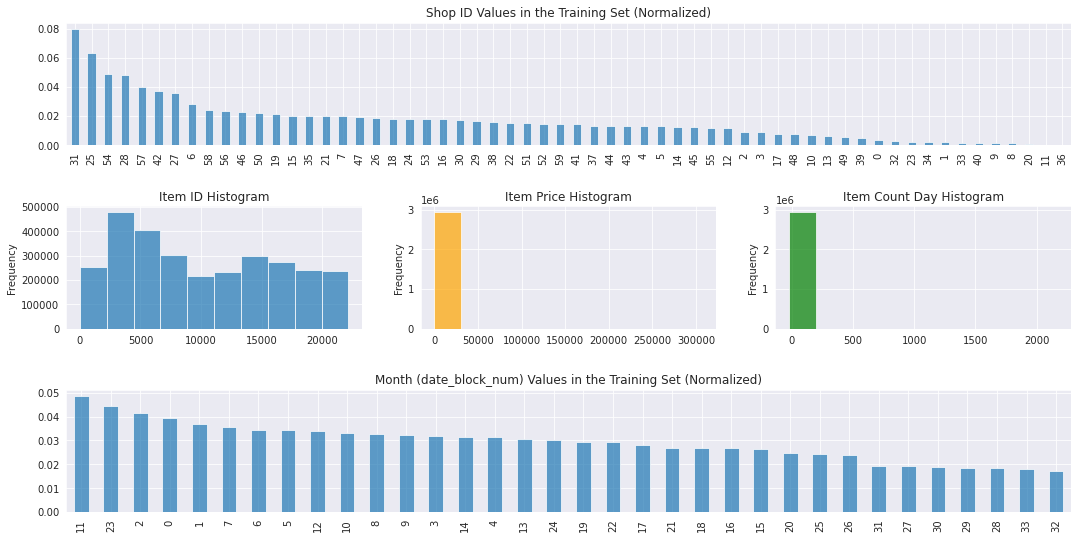

In [15]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
sales_train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
sales_train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
sales_train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
sales_train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
sales_train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

1. 60 'shop_id's but there is an uneven distribtution of these in the dataset. Four (<7%) of these shops make up ~25 percent of this dataset. These are shops (31, 25, 54, 28).
2. The Item IDs seem to have variations in frequency. We can't attribute a reason to this yet but we can inspect this further. Certain cateogeries are bound to sell better and maybe items under the same category are closer to each other as far as their ID distributions are concerned
3. From the vast empty spaces in the histograms of 'item_price' and 'item_cnt_day', we can infer that there are outliers in their distribution. Let's write some simple code below to put a value to these outliers.
4. Plotting the individual months from January 2013 to October 2015, it is interesting to see that the block month 12, corresponding to December 2013, had the highest number of sales. Month 23, which corresponds to December 2014, had the second highest number of sales. Shortly, we will use some better graphs to observe the monthly sale trends.

In [16]:
import missingno as msno

#### Missing values

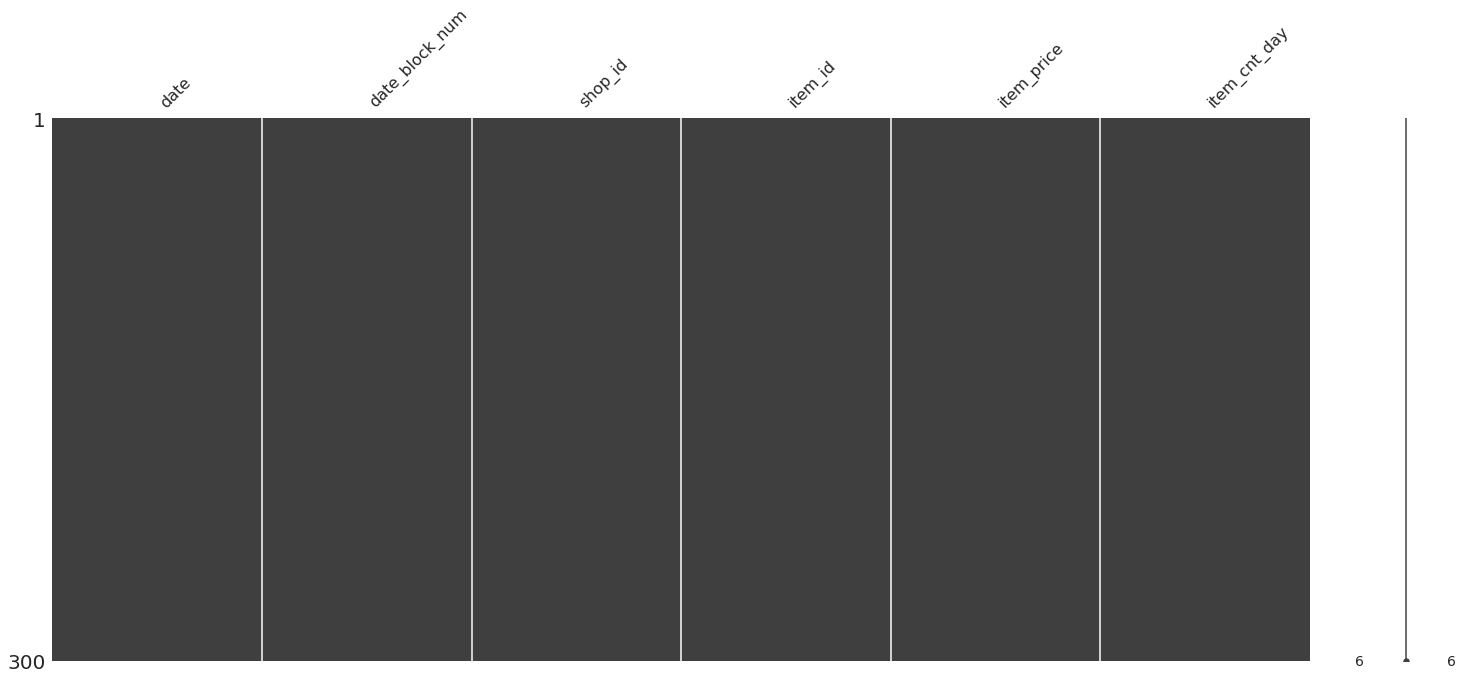

In [17]:
#for a sample of 300
msno.matrix(sales_train.sample(300))

In [18]:
sales_train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


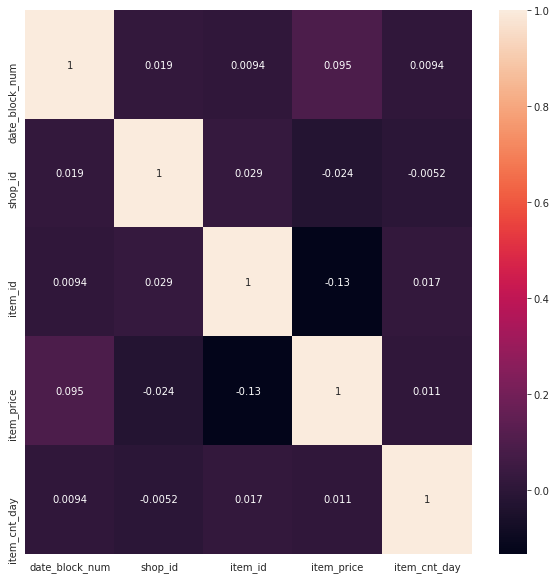

In [19]:
f, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(sales_train.corr(), annot=True, ax=ax)

In [20]:
import datetime
sales_train['date'] = pd.to_datetime(sales_train['date'])

In [21]:
sales_train.set_index(['date'],inplace=True)
sales_train = sales_train['item_cnt_day'].resample('D').sum()
d = pd.DataFrame(sales_train)

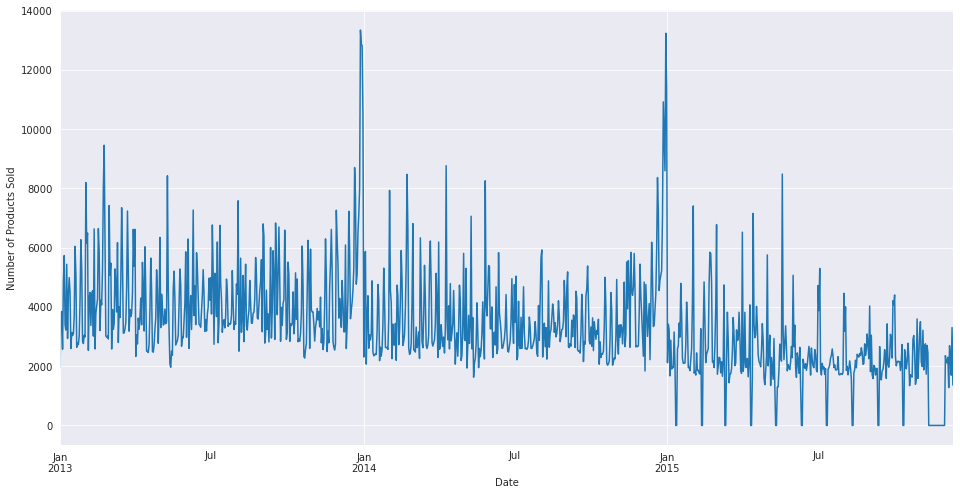

In [22]:
plt.figure(figsize=(16,8))
d['item_cnt_day'].plot()
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

In [23]:
sales_sampled = sales_train.sample(n = 10000)
sns.pairplot(sales_sampled[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']])
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

#### Outliers

In [24]:
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")

In [25]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

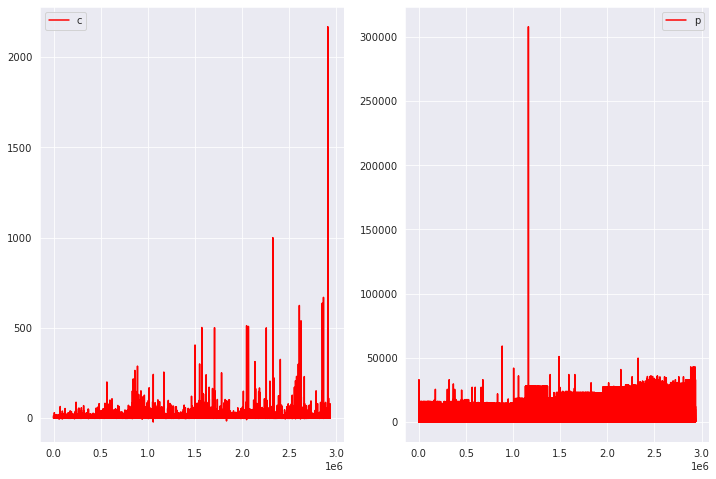

In [26]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(sales_train['item_cnt_day'], color='red')
plt.legend(('count'))

plt.subplot(1,2,2) 
plt.plot(sales_train['item_price'], color='red')
plt.legend('price')

In [27]:
sales_train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1


Convert sales.date form string to datetime

In [28]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
print('Min date from train set: %s' % sales_train['date'].min().date())
print('Max date from train set: %s' % sales_train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


#### Data leakages

In [29]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test
lk_train = sales_train[sales_train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [30]:
print('Data set size before leaking:', sales_train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [31]:
monthly_sales=sales_train.groupby(['date_block_num','shop_id','item_id'])[
    'date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})
monthly_sales.head(15)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-10-01 2013-10-01      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-06-01 2013-06-01      193.0          1.0
                       96      2013-10-01 2013-10-01       70.0          1.0
                       98      2013-01-13 2013-12-01      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-17 2013-11-01       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-09-01 2013-09-01      258.0          1.0

 Total sales per month

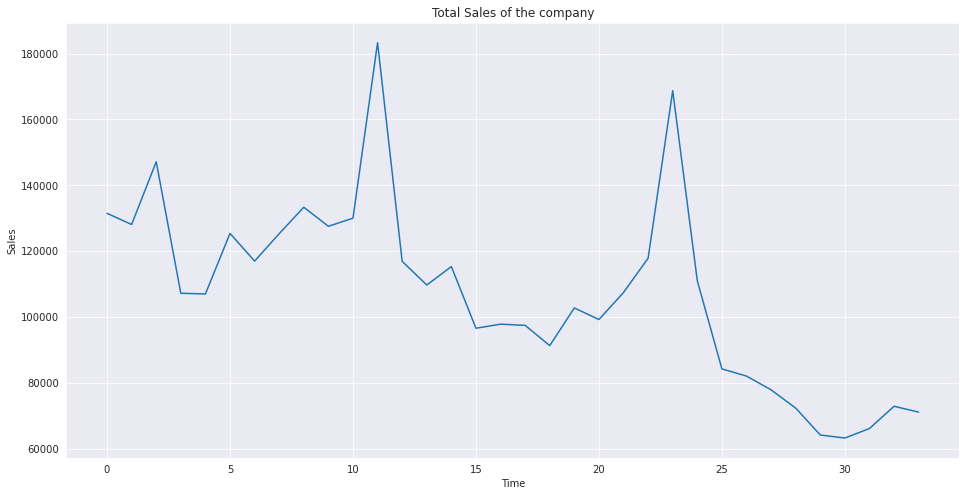

In [32]:
ts = sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

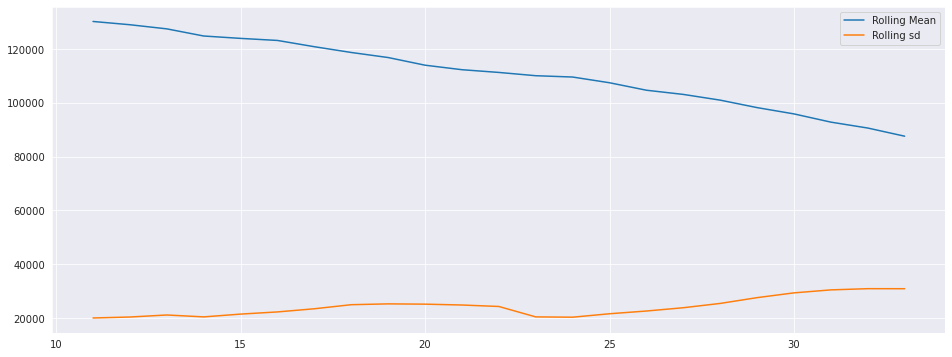

In [33]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

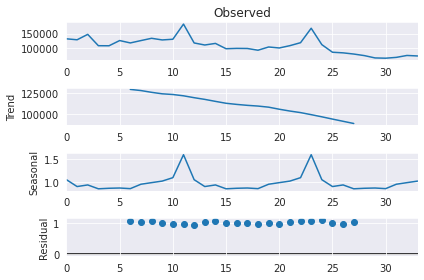

In [34]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

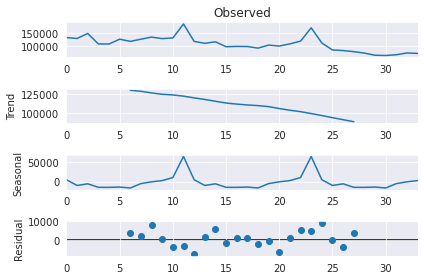

In [35]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [36]:
df = d.values
df = df.astype('float32')

scaler = MinMaxScaler(feature_range=(-1,1))
ts = scaler.fit_transform(df)

In [37]:
timestep = 30

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])

In [38]:
X=np.asanyarray(X)
Y=np.asanyarray(Y)

k = 850
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]  

In [39]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=200, verbose=0)

In [40]:
Xtest = X[k:,:,:]  
Ytest= Y[k:] 

In [41]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

1842986.2

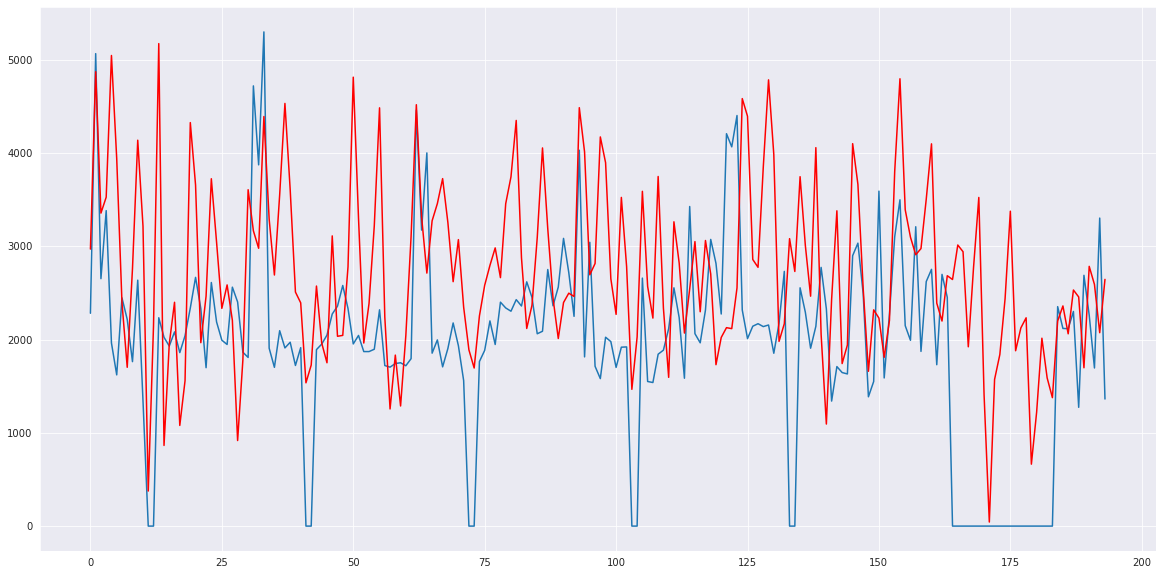

In [42]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()

2 version + Data cleaning

the same data

In [43]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40
test.loc[test.shop_id == 39, 'shop_id'] = 40

In [44]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [45]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'], shops['shop_name'] = shops['shop_name'].str.split(' ', 1).str
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'unkown')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,орджоникидзе фран,0,якутск,unkown
1,тц центральный фран,1,якутск,тц
2,тц мега,2,адыгея,тц
3,трк октябрькиномир,3,балашиха,трк
4,тц волга молл,4,волжский,тц


In [46]:
print('Shops number:', shops['shop_id'].nunique())
print('Shop names number:', shops['shop_name'].nunique())
print('Shop cities number:', shops['shop_city'].nunique())
print('Shop types number:', shops['shop_type'].nunique())

Shops number: 60
Shop names number: 56
Shop cities number: 31
Shop types number: 6


In [47]:
sales_train.loc[sales_train['shop_id'] == 11, 'shop_id'] = 10
shops.loc[shops['shop_id'] == 11, 'shop_id'] = 10

sales_train.loc[sales_train['shop_id'] == 23, 'shop_id'] = 24
shops.loc[shops['shop_id'] == 23, 'shop_id'] = 24

sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
shops.loc[shops['shop_id'] == 0, 'shop_id'] = 57

sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
shops.loc[shops['shop_id'] == 1, 'shop_id'] = 58

sales_train.loc[sales_train['shop_id'] == 40, 'shop_id'] = 39
shops.loc[shops['shop_id'] == 40, 'shop_id'] = 39

In [48]:
shops = shops.drop_duplicates(subset = 'shop_id')

In [49]:
print('Shops number:', shops['shop_id'].nunique())
print('Shop names number:', shops['shop_name'].nunique())
print('Shop cities number:', shops['shop_city'].nunique())
print('Shop types number:', shops['shop_type'].nunique())

Shops number: 55
Shop names number: 51
Shop cities number: 31
Shop types number: 6


In [50]:
def clean_names(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
        df[col] = df[col].str.strip()
        df.loc[df[col] == '', col] = 'unknown'

In [51]:
items['item_name'], items['item_type'] = items['item_name'].str.split('[', 1).str
items['item_name'], items['item_subtype'] = items['item_name'].str.split('(', 1).str
clean_names(items, ['item_name', 'item_type', 'item_subtype'])
items = items.fillna('unkown')
items.head()

,item_name,item_id,item_category_id,item_type,item_subtype
0,во власти наваждения,0,40,unkown,пласт d
1,abbyy finereader 12 professional edition full,1,76,pc цифровая версия,unkown
2,в лучах славы,2,40,unkown,unv d
3,голубая волна,3,40,unkown,univ d
4,коробка,4,40,unkown,стекло d


In [52]:
print('Number of items:', items['item_id'].nunique())
print('Number of item_name:', items['item_name'].nunique())
print('Number of item_type:', items['item_type'].nunique())
print('Number of item_subtype:', items['item_subtype'].nunique())

Number of items: 22170
Number of item_name: 18121
Number of item_type: 170
Number of item_subtype: 1536


In [53]:
data = sales_train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [54]:
data.reset_index(inplace = True)

In [55]:
data = pd.merge(test,data,on = ['item_id','shop_id'],how = 'left')

In [56]:
dataset.fillna(0,inplace = True)
data.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)

NameError: name 'dataset' is not defined

In [57]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(data.values[:,:-2],axis = 2)
# the last column is our label
y_train = data.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(data.values[:,2:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 35, 1) (214200, 1) (214200, 35, 1)


In [58]:
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (33,1)))
my_model.add(Dropout(0.4))
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [59]:
my_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

ValueError: Error when checking input: expected lstm_1_input to have shape (33, 1) but got array with shape (35, 1)

In [60]:
# creating submission file 
submission_pfs = my_model.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_pfs.csv',index = False)

ValueError: Error when checking input: expected lstm_1_input to have shape (33, 1) but got array with shape (35, 1)